In [7]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import os
import torch
from PIL import Image

In [8]:
model_root_dir = "/home/omote/local-share-data_ssd/huggingface_model_weights"
model_id = os.path.join(model_root_dir, "Qwen/Qwen2.5-VL-7B-Instruct")
cache_dir = "/home/omote/local-share-data_ssd/huggingface_cache"

# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id, cache_dir=cache_dir, torch_dtype=torch.bfloat16
)

model.to("cuda:0")
model.eval()


Loading checkpoint shards: 100%|██████████| 5/5 [00:00<00:00, 25.96it/s]


Qwen2_5_VLForConditionalGeneration(
  (visual): Qwen2_5_VisionTransformerPretrainedModel(
    (patch_embed): Qwen2_5_VisionPatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2_5_VLVisionBlock(
        (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
        (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
        (attn): Qwen2_5_VLVisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): Qwen2_5_VLMLP(
          (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
          (act_fn): SiLU()
        )
      )
    )
    (merger): Qwen2_5_VLPatchMerger

In [9]:
processor = AutoProcessor.from_pretrained(model_id, cache_dir=cache_dir)

In [10]:
messages = [
    {
        "role": "user",
        "content": [

            # {"type": "text", "text": "Please output bbox coordinates and names of every object in this image in JSON format"},
            {"type": "text", "text": "Locate \"The creature on the left side of the woman\", report the bbox coordinates in JSON format."},
            {
                "type": "image",
                "image": Image.open("../demo.jpeg"), #"https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)


In [11]:
print(text)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Locate "The creature on the left side of the woman", report the bbox coordinates in JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant



In [23]:
image_inputs, video_inputs = process_vision_info([messages])
print(image_inputs)
print(video_inputs)

[<PIL.Image.Image image mode=RGB size=2044x1372 at 0x14B3113F3E90>]
None


In [13]:
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda:0")
print(inputs)


{'input_ids': tensor([[151644,   8948,    198,  ..., 151644,  77091,    198]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:0'), 'pixel_values': tensor([[ 0.8501,  0.8501,  0.8647,  ...,  1.3922,  1.3922,  1.3922],
        [ 0.9376,  0.9376,  0.9376,  ...,  1.4491,  1.4491,  1.4491],
        [ 0.9084,  0.9376,  0.9376,  ...,  1.4065,  1.4207,  1.4207],
        ...,
        [-0.1280, -0.1280, -0.1426,  ..., -0.2431, -0.2715, -0.3000],
        [-0.3324, -0.3324, -0.3032,  ..., -0.3000, -0.2715, -0.2857],
        [-0.3762, -0.4054, -0.4054,  ..., -0.4279, -0.4422, -0.4564]],
       device='cuda:0'), 'image_grid_thw': tensor([[  1,  98, 146]], device='cuda:0')}


In [14]:



# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=400, do_sample=False,temperature=0)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=False, clean_up_tokenization_spaces=False
)
print(output_text)

/home/omote/cluster_project/iam2/.venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


['```json\n[\n\t{"bbox_2d": [458, 586, 1190, 1213], "label": "The creature on the left side of the woman"}\n]\n```<|im_end|>']


In [17]:
import re
def extract_bbox_from_text(ans):
    pattern = re.compile(r'\[((\d+,\s*){3}(\d+\s*))\]')
    match_list = pattern.findall(ans)

    if len(match_list) > 0:
        answer = [list(map(float,match[0].split(","))) for match in match_list]
    else:
        answer = "FAILED"
    return answer

In [22]:
bbox = extract_bbox_from_text(output_text[0])
print(bbox[0])

[458.0, 586.0, 1190.0, 1213.0]


In [19]:
vocab = processor.tokenizer.get_vocab()

In [20]:
print(len(vocab))

151665


In [27]:
print(vocab["<|box_start|>"])

151648


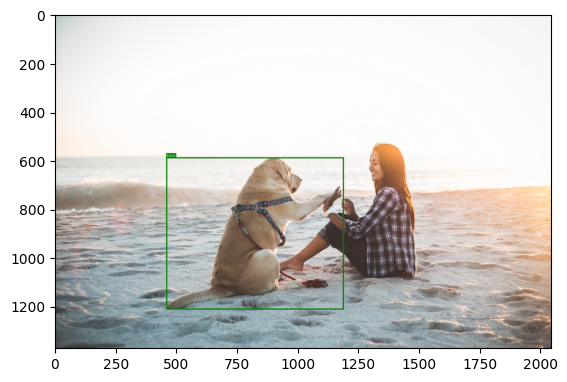

In [16]:
import imgviz
import numpy as np
import matplotlib.pyplot as plt
def visualize_bbox(image, bbox, caption):
    bboxes = np.array([bbox[1],bbox[0],bbox[3],bbox[2]]).astype(np.int32).reshape(-1, 4)
    labels = [2]
    image = imgviz.instances2rgb(np.array(image), bboxes=bboxes, labels=labels,captions=[caption],font_size=16)

    plt.imshow(image)
    plt.show()
    
visualize_bbox(image_inputs[0], [458, 586, 1190, 1213], "test")

In [64]:
from PIL import Image
original_image = Image.open("../demo.jpeg")
print(original_image.size)
print(image_inputs[0].size)

(2048, 1365)
(2044, 1372)
